In [1]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
train_path = "/kaggle/input/dataset-llm/train.json"
valid_path = "/kaggle/input/dataset-llm/val.json"
test_path = "/kaggle/input/dataset-llm/test.json"

## Data Preprocessing

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import json
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm


# -------- Tokenizer --------
def nltk_tokenizer(text):
    return word_tokenize(text.lower())


# -------- Read JSON (for DBPedia) --------
def load_dbpedia_data(train_path, val_path, test_path=None):
    # ---- train ----
    with open(train_path, "r", encoding="utf-8") as f:
        train_data = json.load(f)
    train_texts = [item["text"] for item in train_data]
    train_labels = [int(item["label"]) for item in train_data]

    # ---- val ----
    with open(val_path, "r", encoding="utf-8") as f:
        val_data = json.load(f)
    val_texts = [item["text"] for item in val_data]
    val_labels = [int(item["label"]) for item in val_data]

    # ---- test ----
    if test_path is not None:
        with open(test_path, "r", encoding="utf-8") as f:
            test_data = json.load(f)
        test_texts = [item["text"] for item in test_data]
        test_ids = [item.get("id", i) for i, item in enumerate(test_data)]
    else:
        test_texts, test_ids = [], []

    num_classes = max(train_labels + val_labels) + 1

    return train_texts, train_labels, val_texts, val_labels, test_texts, test_ids, num_classes


# -------- Vocab --------
class Vocab:
    def __init__(self, tokens_list, min_freq=1):
        counter = Counter()
        for tokens in tokens_list:
            counter.update(tokens)

        self.itos = ["<unk>", "<pad>"] + [tok for tok, freq in counter.items() if freq >= min_freq]
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi.get(token, self.stoi["<unk>"])


# -------- Dataset --------
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, vocab=None, max_len=128):
        self.tokens_list = [nltk_tokenizer(text) for text in tqdm(texts, desc="Tokenizing")]
        self.labels = labels
        self.max_len = max_len

        if vocab is None:
            self.vocab = Vocab(self.tokens_list)
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        tokens = self.tokens_list[idx]
        ids = [self.vocab[tok] for tok in tokens[:self.max_len]]

        if len(ids) < self.max_len:
            ids += [self.vocab["<pad>"]] * (self.max_len - len(ids))

        ids = torch.tensor(ids, dtype=torch.long)

        if self.labels is not None:
            label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
            return ids, label
        else:
            return ids


# -------- DataLoader --------
def get_dataloaders(train_texts, train_labels, val_texts, val_labels,
                    batch_size=32, max_len=128):
    train_dataset = TextDataset(train_texts, train_labels, max_len=max_len)
    val_dataset = TextDataset(val_texts, val_labels, vocab=train_dataset.vocab, max_len=max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, train_dataset.vocab


# -------- Test Loader --------
def get_test_loader(test_texts, vocab, batch_size=32, max_len=128):
    test_dataset = TextDataset(test_texts, labels=None, vocab=vocab, max_len=max_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader


### Check dataset length

In [5]:
# check the average length of tokens in training data
train_texts, train_labels, val_texts, val_labels, _, _, num_classes = load_dbpedia_data(
        train_path,
        valid_path,
        None
)

total_len = sum(len(nltk_tokenizer(text)) for text in train_texts)
avg_len = total_len / len(train_texts)
print(f"Average token length in training data: {avg_len:.2f}")

total_len_val = sum(len(nltk_tokenizer(text)) for text in val_texts)
avg_len_val = total_len_val / len(val_texts)
print(f"Average token length in validation data: {avg_len_val:.2f}")

Average token length in training data: 50.60
Average token length in validation data: 50.33


## 1. Basic SSM

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- basic SSM ---
class DiagonalSSM(nn.Module):
    def __init__(self, state_size: int, dt_init: float = 1.0, init_scale: float = 0.1):
        super().__init__()
        self.state_size = state_size

        # --- Continuous-time parameters ---
        # A: diagonal, so is one-dimensional, negative for stability
        self.A = nn.Parameter(-torch.rand(state_size) * init_scale)

        # B, C: learnable projections
        self.B = nn.Parameter(torch.randn(state_size) * init_scale)
        self.C = nn.Parameter(torch.randn(state_size) * init_scale)

        # Discretization step (Δt)
        self.dt = nn.Parameter(torch.ones(1) * dt_init)

        # Buffers for discretized
        self.register_buffer("A_bar", torch.zeros(state_size))
        self.register_buffer("B_bar", torch.zeros(state_size))

        self._discretize()

    def _discretize(self):
        """
        Compute discrete-time:
            A_bar = exp(A * dt)
            B_bar = (exp(A * dt) - 1) / A * B
        (diagonal version of zero-order hold discretization)
        """
        A_dt = self.A * self.dt  # (state_size)
        self.A_bar = torch.exp(A_dt)

        # Handle division by zero for A ≈ 0
        self.B_bar = torch.where(
            self.A.abs() > 1e-5,
            (self.A_bar - 1.0) / self.A * self.B,
            self.dt * self.B,
        )

    def forward(self, u):
        """
        u: (B, L, 1)
        return: (B, L, state_size)
        """
        B, L, _ = u.shape
        self._discretize()  

        # State h: (B, state_size)
        h = torch.zeros(B, self.state_size, device=u.device)
        outputs = []

        # scan over sequence
        for t in range(L):
            u_t = u[:, t, 0]                     
            h = self.A_bar * h + self.B_bar * u_t.unsqueeze(-1)
            y_t = h * self.C                    
            outputs.append(y_t)

        return torch.stack(outputs, dim=1)

# --- Block ---
class SSMBlock(nn.Module):
    def __init__(self, in_dim: int, state_size: int, dropout: float = 0.1):
        super().__init__()
        self.proj_in = nn.Linear(in_dim, 1)
        self.ssm = DiagonalSSM(state_size)
        self.proj_out = nn.Linear(state_size, in_dim)
        self.gate = nn.Sigmoid()
        self.norm = nn.LayerNorm(in_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        u = self.proj_in(x)
        y = self.ssm(u)
        y = self.proj_out(y)
        y = self.gate(y) * y
        y = self.dropout(y)
        return self.norm(residual + y)


# --- Text Classifier ---
class SSMTextClassifier(nn.Module):
    def __init__(self, vocab_size: int, num_classes: int, state_size: int, num_layers: int,
             emb_dim: int = 128, dropout: float = 0.1, pad_idx: int = 0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.blocks = nn.ModuleList([SSMBlock(emb_dim, state_size, dropout) for _ in range(num_layers)])
        self.head = nn.Linear(emb_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        x = self.emb(input_ids)
        for blk in self.blocks:
            x = blk(x)
        pooled = x.mean(dim=1)
        return self.head(self.dropout(pooled))

In [10]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt


def train_SSM(train_texts, train_labels, val_texts, val_labels,
              num_classes, epochs, batch_size, max_len,
              emb_dim, state_size, num_layers, lr,
              device="cuda"):

    train_loader, val_loader, vocab = get_dataloaders(
        train_texts, train_labels, val_texts, val_labels,
        batch_size=batch_size, max_len=max_len
    )

    pad_idx = vocab.stoi["<pad>"]
    model = SSMTextClassifier(
        vocab_size=len(vocab),
        num_classes=num_classes,
        emb_dim=emb_dim,
        state_size=state_size,
        num_layers=num_layers,
        dropout=0.1,
        pad_idx=pad_idx
    ).to(device)

    classes = np.unique(train_labels)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler("cuda")

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # --- training ---
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}", unit="batch")

        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                logits = model(xb)
                loss = criterion(logits, yb)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{(correct / total):.4f}"
            })

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            pbar_val = tqdm(val_loader, desc=f"Valid {epoch+1}/{epochs}", unit="batch")
            for xb, yb in pbar_val:
                xb, yb = xb.to(device), yb.to(device)
                with torch.amp.autocast("cuda"):
                    logits = model(xb)
                    loss = criterion(logits, yb)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)

        train_acc = correct / total
        val_acc = val_correct / val_total
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()    

    return model, vocab

In [9]:
import time 

def main_SSM(
    train_path,
    valid_path,
    epochs,
    batch_size,
    max_len,
    emb_dim,
    state_size,
    num_layers,
    lr
):

    train_texts, train_labels, val_texts, val_labels, _, _, num_classes = load_dbpedia_data(
        train_path,
        valid_path,
        None
    )

    start_time = time.time()
    model, vocab = train_SSM(
        train_texts, train_labels, val_texts, val_labels,
        num_classes=num_classes,
        epochs=epochs,
        batch_size=batch_size,
        max_len=max_len,
        emb_dim=emb_dim,
        state_size=state_size,
        num_layers=num_layers,
        lr=lr
    )
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    return model, vocab


Valid 1/10: 100%|██████████| 125/125 [00:01<00:00, 72.00batch/s]


Epoch 1/10 | Train Acc: 0.1914 | Val Acc: 0.3650 | Train Loss: 2.4378 | Val Loss: 2.0073


Valid 2/10: 100%|██████████| 125/125 [00:01<00:00, 71.27batch/s]


Epoch 2/10 | Train Acc: 0.3736 | Val Acc: 0.4020 | Train Loss: 1.8404 | Val Loss: 1.6946


Valid 3/10: 100%|██████████| 125/125 [00:01<00:00, 71.91batch/s]


Epoch 3/10 | Train Acc: 0.4582 | Val Acc: 0.4395 | Train Loss: 1.5447 | Val Loss: 1.6157


Valid 4/10: 100%|██████████| 125/125 [00:01<00:00, 71.37batch/s]


Epoch 4/10 | Train Acc: 0.5294 | Val Acc: 0.4580 | Train Loss: 1.3538 | Val Loss: 1.4980


Valid 5/10: 100%|██████████| 125/125 [00:01<00:00, 72.26batch/s]


Epoch 5/10 | Train Acc: 0.5676 | Val Acc: 0.5610 | Train Loss: 1.2239 | Val Loss: 1.3059


Valid 6/10: 100%|██████████| 125/125 [00:01<00:00, 73.26batch/s]


Epoch 6/10 | Train Acc: 0.6266 | Val Acc: 0.5585 | Train Loss: 1.0719 | Val Loss: 1.2861


Valid 7/10: 100%|██████████| 125/125 [00:01<00:00, 70.86batch/s]


Epoch 7/10 | Train Acc: 0.6784 | Val Acc: 0.5740 | Train Loss: 0.9498 | Val Loss: 1.2453


Valid 8/10: 100%|██████████| 125/125 [00:01<00:00, 72.94batch/s]


Epoch 8/10 | Train Acc: 0.7112 | Val Acc: 0.5535 | Train Loss: 0.8526 | Val Loss: 1.3605


Valid 9/10: 100%|██████████| 125/125 [00:01<00:00, 72.41batch/s]


Epoch 9/10 | Train Acc: 0.7484 | Val Acc: 0.5760 | Train Loss: 0.7658 | Val Loss: 1.3499


Valid 10/10: 100%|██████████| 125/125 [00:01<00:00, 71.38batch/s]


Epoch 10/10 | Train Acc: 0.7660 | Val Acc: 0.5785 | Train Loss: 0.6977 | Val Loss: 1.3863
Training time: 266.81 seconds


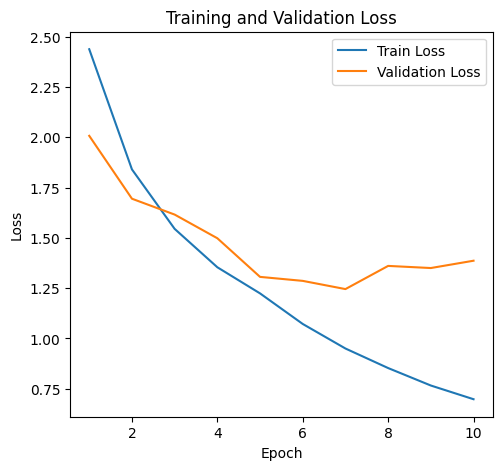

In [39]:
model, vocab = main_SSM(
    train_path, valid_path,
    epochs=10,
    batch_size=16,
    max_len=64,
    emb_dim=128,
    state_size=32,
    num_layers=3,
    lr=5e-4
)

In [12]:
# predict on test.json
def predict_test(model, vocab, test_path, batch_size=32, max_len=128, device="cuda"):
    test_texts, test_ids = load_dbpedia_data(train_path, valid_path, test_path)[4:6]
    test_loader = get_test_loader(test_texts, vocab, batch_size=batch_size, max_len=max_len)

    model.eval()
    predictions = []
    with torch.no_grad():
        for xb in tqdm(test_loader, desc="Predicting", unit="batch"):
            xb = xb.to(device)
            with torch.amp.autocast("cuda"):
                logits = model(xb)
            preds = logits.argmax(dim=1).cpu().tolist()
            predictions.extend(preds)

    return list(zip(test_ids, predictions))

preds = predict_test(model, vocab, test_path, batch_size=16, max_len=64, device="cuda")

with open("base_submission.csv", "w") as f:
    f.write("id,label\n")
    for idx, label in preds:
        f.write(f"{idx},{label}\n")

Predicting: 100%|██████████| 125/125 [00:01<00:00, 72.61batch/s]


## 2. FFT-based Convolutional SSM

In [13]:
# --- FFT-based Convolutional SSM (Simplified S4) ---
import torch
import torch.nn as nn
import torch.nn.functional as F

class FFTSSMBlock(nn.Module):
    def __init__(self, seq_len: int, in_dim: int, dropout: float = 0.1):
        super().__init__()
        self.seq_len = seq_len
        self.in_dim = in_dim

        self.A_raw = nn.Parameter(torch.randn(in_dim))       # shape (D,)
        self.B = nn.Parameter(torch.randn(in_dim))           # shape (D,)
        self.C = nn.Parameter(torch.randn(in_dim))           # shape (D,)

        
        self.proj_in = nn.Linear(in_dim, in_dim)
        self.proj_out = nn.Linear(in_dim, in_dim)

        self.norm = nn.LayerNorm(in_dim)
        self.dropout = nn.Dropout(dropout)
        self.gate = nn.Sigmoid()

    def compute_kernel(self, L):
        """
        Compute convolution kernel K of shape (in_dim, L)
        Using A, B, C with exponential decay (S4D-like)
        """
        t = torch.arange(L, device=self.A_raw.device, dtype=torch.float32)  # (L,)
        A = -F.softplus(self.A_raw)  # ensure stability: A < 0
        decay = torch.exp(torch.outer(t, A))  # (L, D)
        K = decay * (self.C * self.B) * 0.1   # (L, D)
        return K.T  # -> (D, L)

    def forward(self, x):
        """
        x: (B, L, D)
        """
        B, L, D = x.shape
        residual = x

        #=== input projection ===#
        u = self.proj_in(x)  # (B, L, D)

        #=== SSM Kernel ===#
        K = self.compute_kernel(L)  # (D, L)

        #=== FFT convolution ===#
        # We convolve each channel separately
        # u: (B, D, L)
        u_f = torch.fft.rfft(u.transpose(1, 2), n=2*L)   # (B, D, ?)
        k_f = torch.fft.rfft(K, n=2*L)                   # (D, ?)

        # Multiply in frequency domain
        y_f = u_f * k_f.unsqueeze(0)                     # (B, D, ?)

        # Inverse FFT to time domain
        y = torch.fft.irfft(y_f, n=2*L)[..., :L]         # (B, D, L)
        y = y.transpose(1, 2)                            # (B, L, D)

        #=== output projection + gate ===#
        y = self.proj_out(y)
        y = self.gate(y) * y
        y = self.dropout(y)

        return self.norm(residual + y)

class S4TextClassifier(nn.Module):
    def __init__(self, vocab_size: int, num_classes: int, seq_len: int,
                 emb_dim=128, num_layers=2, dropout=0.1, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        self.blocks = nn.ModuleList([
            FFTSSMBlock(seq_len, emb_dim, dropout)
            for _ in range(num_layers)
        ])

        self.head = nn.Linear(emb_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        x = self.emb(input_ids)

        for blk in self.blocks:
            x = blk(x)

        pooled = x.mean(dim=1)
        return self.head(self.dropout(pooled))

In [21]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight

def train_S4(
    train_texts, train_labels,
    val_texts, val_labels,
    num_classes,
    epochs=3,
    batch_size=32,
    max_len=128,
    emb_dim=256,
    num_layers=4,
    lr=1e-3,
    device="cuda"
):

    train_loader, val_loader, vocab = get_dataloaders(
        train_texts, train_labels, val_texts, val_labels,
        batch_size=batch_size, max_len=max_len
    )

    pad_idx = vocab.stoi["<pad>"]
    model = S4TextClassifier(
        vocab_size=len(vocab),
        num_classes=num_classes,
        seq_len=max_len,
        emb_dim=emb_dim,
        num_layers=num_layers,
        dropout=0.1,
        pad_idx=pad_idx
    ).to(device)

    classes = np.unique(train_labels)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler("cuda")

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}", unit="batch")

        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                logits = model(xb)
                loss = criterion(logits, yb)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{(correct / total):.4f}"
            })

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            pbar_val = tqdm(val_loader, desc=f"Valid {epoch+1}/{epochs}", unit="batch")
            for xb, yb in pbar_val:
                xb, yb = xb.to(device), yb.to(device)
                with torch.amp.autocast("cuda"):
                    logits = model(xb)
                    loss = criterion(logits, yb)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)

        train_acc = correct / total
        val_acc = val_correct / val_total
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()    

    return model, vocab


In [40]:
def main_S4(
    train_path,
    val_path,
    test_path,
    epochs,
    batch_size,
    max_len,
    emb_dim,
    num_layers,
    lr
):

    train_texts, train_labels, val_texts, val_labels, test_texts, test_ids, num_classes = load_dbpedia_data(
        train_path, val_path, test_path
    )
    
    start_time = time.time()
    model, vocab = train_S4(
        train_texts, train_labels,
        val_texts, val_labels,
        num_classes=num_classes,
        epochs=epochs,
        batch_size=batch_size,
        max_len=max_len,
        emb_dim=emb_dim,
        num_layers=num_layers,
        lr=lr
    )
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    return model, vocab


Valid 1/25: 100%|██████████| 32/32 [00:00<00:00, 153.44batch/s]


Epoch 1/25 | Train Acc: 0.1100 | Val Acc: 0.1540 | Train Loss: 2.6091 | Val Loss: 2.5500


Valid 2/25: 100%|██████████| 32/32 [00:00<00:00, 155.03batch/s]


Epoch 2/25 | Train Acc: 0.2076 | Val Acc: 0.2305 | Train Loss: 2.5149 | Val Loss: 2.4569


Valid 3/25: 100%|██████████| 32/32 [00:00<00:00, 146.58batch/s]


Epoch 3/25 | Train Acc: 0.2814 | Val Acc: 0.2900 | Train Loss: 2.3735 | Val Loss: 2.3291


Valid 4/25: 100%|██████████| 32/32 [00:00<00:00, 149.53batch/s]


Epoch 4/25 | Train Acc: 0.3698 | Val Acc: 0.3805 | Train Loss: 2.1884 | Val Loss: 2.1839


Valid 5/25: 100%|██████████| 32/32 [00:00<00:00, 152.53batch/s]


Epoch 5/25 | Train Acc: 0.4630 | Val Acc: 0.4355 | Train Loss: 2.0039 | Val Loss: 2.0467


Valid 6/25: 100%|██████████| 32/32 [00:00<00:00, 151.56batch/s]


Epoch 6/25 | Train Acc: 0.5326 | Val Acc: 0.4735 | Train Loss: 1.8409 | Val Loss: 1.9399


Valid 7/25: 100%|██████████| 32/32 [00:00<00:00, 152.26batch/s]


Epoch 7/25 | Train Acc: 0.5916 | Val Acc: 0.5250 | Train Loss: 1.6569 | Val Loss: 1.7606


Valid 8/25: 100%|██████████| 32/32 [00:00<00:00, 153.55batch/s]


Epoch 8/25 | Train Acc: 0.6332 | Val Acc: 0.5645 | Train Loss: 1.4458 | Val Loss: 1.5810


Valid 9/25: 100%|██████████| 32/32 [00:00<00:00, 152.72batch/s]


Epoch 9/25 | Train Acc: 0.6728 | Val Acc: 0.5870 | Train Loss: 1.2674 | Val Loss: 1.4630


Valid 10/25: 100%|██████████| 32/32 [00:00<00:00, 152.58batch/s]


Epoch 10/25 | Train Acc: 0.7012 | Val Acc: 0.6005 | Train Loss: 1.1272 | Val Loss: 1.3887


Valid 11/25: 100%|██████████| 32/32 [00:00<00:00, 150.78batch/s]


Epoch 11/25 | Train Acc: 0.7206 | Val Acc: 0.6180 | Train Loss: 1.0112 | Val Loss: 1.3475


Valid 12/25: 100%|██████████| 32/32 [00:00<00:00, 148.96batch/s]


Epoch 12/25 | Train Acc: 0.7460 | Val Acc: 0.6295 | Train Loss: 0.9162 | Val Loss: 1.2746


Valid 13/25: 100%|██████████| 32/32 [00:00<00:00, 154.09batch/s]


Epoch 13/25 | Train Acc: 0.7626 | Val Acc: 0.6520 | Train Loss: 0.8247 | Val Loss: 1.1775


Valid 14/25: 100%|██████████| 32/32 [00:00<00:00, 155.56batch/s]


Epoch 14/25 | Train Acc: 0.7846 | Val Acc: 0.6515 | Train Loss: 0.7568 | Val Loss: 1.1963


Valid 15/25: 100%|██████████| 32/32 [00:00<00:00, 153.33batch/s]


Epoch 15/25 | Train Acc: 0.8004 | Val Acc: 0.6635 | Train Loss: 0.6827 | Val Loss: 1.1444


Valid 16/25: 100%|██████████| 32/32 [00:00<00:00, 154.41batch/s]


Epoch 16/25 | Train Acc: 0.8158 | Val Acc: 0.6610 | Train Loss: 0.6322 | Val Loss: 1.1709


Valid 17/25: 100%|██████████| 32/32 [00:00<00:00, 151.10batch/s]


Epoch 17/25 | Train Acc: 0.8320 | Val Acc: 0.6685 | Train Loss: 0.5658 | Val Loss: 1.1455


Valid 18/25: 100%|██████████| 32/32 [00:00<00:00, 145.62batch/s]


Epoch 18/25 | Train Acc: 0.8466 | Val Acc: 0.6805 | Train Loss: 0.5195 | Val Loss: 1.1196


Valid 19/25: 100%|██████████| 32/32 [00:00<00:00, 151.27batch/s]


Epoch 19/25 | Train Acc: 0.8550 | Val Acc: 0.6915 | Train Loss: 0.4778 | Val Loss: 1.0886


Valid 20/25: 100%|██████████| 32/32 [00:00<00:00, 155.42batch/s]


Epoch 20/25 | Train Acc: 0.8678 | Val Acc: 0.6850 | Train Loss: 0.4399 | Val Loss: 1.1479


Valid 21/25: 100%|██████████| 32/32 [00:00<00:00, 151.18batch/s]


Epoch 21/25 | Train Acc: 0.8788 | Val Acc: 0.6760 | Train Loss: 0.4121 | Val Loss: 1.1906


Valid 22/25: 100%|██████████| 32/32 [00:00<00:00, 155.38batch/s]


Epoch 22/25 | Train Acc: 0.8876 | Val Acc: 0.6905 | Train Loss: 0.3822 | Val Loss: 1.1423


Valid 23/25: 100%|██████████| 32/32 [00:00<00:00, 153.98batch/s]


Epoch 23/25 | Train Acc: 0.8962 | Val Acc: 0.7150 | Train Loss: 0.3479 | Val Loss: 1.0774


Valid 24/25: 100%|██████████| 32/32 [00:00<00:00, 156.59batch/s]


Epoch 24/25 | Train Acc: 0.9028 | Val Acc: 0.7070 | Train Loss: 0.3248 | Val Loss: 1.1433


Valid 25/25: 100%|██████████| 32/32 [00:00<00:00, 144.64batch/s]


Epoch 25/25 | Train Acc: 0.9120 | Val Acc: 0.7140 | Train Loss: 0.2974 | Val Loss: 1.1413
Training time: 58.65 seconds


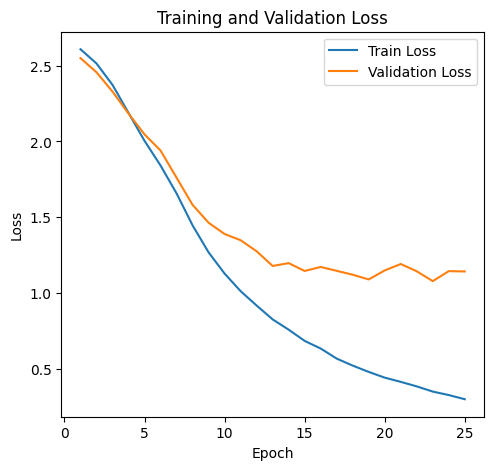

In [41]:
model, vocab = main_S4(
    train_path, valid_path, None,
    epochs=25,
    batch_size=64,
    max_len=64,
    emb_dim=512,
    num_layers=3,
    lr=1e-4
)

In [25]:
def predict_test(model, vocab, test_path, batch_size=32, max_len=128, device="cuda"):
    test_texts, test_ids = load_dbpedia_data(train_path, valid_path, test_path)[4:6]
    test_loader = get_test_loader(test_texts, vocab, batch_size=batch_size, max_len=max_len)

    model.eval()
    predictions = []
    with torch.no_grad():
        for xb in tqdm(test_loader, desc="Predicting", unit="batch"):
            xb = xb.to(device)
            with torch.amp.autocast("cuda"):
                logits = model(xb)
            preds = logits.argmax(dim=1).cpu().tolist()
            predictions.extend(preds)

    return list(zip(test_ids, predictions))

preds = predict_test(model, vocab, test_path, batch_size=16, max_len=64, device="cuda")

with open("fft_submission.csv", "w") as f:
    f.write("id,label\n")
    for idx, label in preds:
        f.write(f"{idx},{label}\n")

Predicting: 100%|██████████| 125/125 [00:00<00:00, 345.81batch/s]


### Observe the difference in training time between S4 and the basic SSM, and discuss the possible reasons behind it
1. For the basic SSM, 10 epochs cost Training time: 266.81 seconds
2. For S4, 25 epochs cost Training time: 58.65 seconds
   
I think the reason is because S4 converts the SSM recurrence into a convolution kernel, allowing full-sequence parallel computation using FFT.
The basic SSM must compute token-by-token, which prevents GPU parallelization and results in O(T) runtime, while S4 reduces this to O(T log T) and leverages efficient CUDA kernels.